In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings

from sklearn.utils import shuffle
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [53]:
# import dataframe and preview first 5 entries
df = pd.read_csv("Training.txt")
df.head(5)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [54]:
# Function to transform date into binary encoding for work hours and non-work hours
def format_date(date):
    
    # convert to datetime object
    date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    
    # if date is during the weekend return 0
    if date.weekday() == 5 or date.weekday() == 6:
        return 0
    # else if it is a weekday during work hours return 1 otherwise return 0
    else:
        if date.time().hour > 8 and date.time().hour < 18:
            return 1
        else:
            return 0
        
# apply function to date column of dataframe
df['date'] = df['date'].map(format_date)

# preview formatted data
df.head(5)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,1,23.18,27.2720,426.0,721.25,0.004793,1
2,1,23.15,27.2675,429.5,714.00,0.004783,1
3,1,23.15,27.2450,426.0,713.50,0.004779,1
4,1,23.15,27.2000,426.0,708.25,0.004772,1
5,1,23.10,27.2000,426.0,704.50,0.004757,1


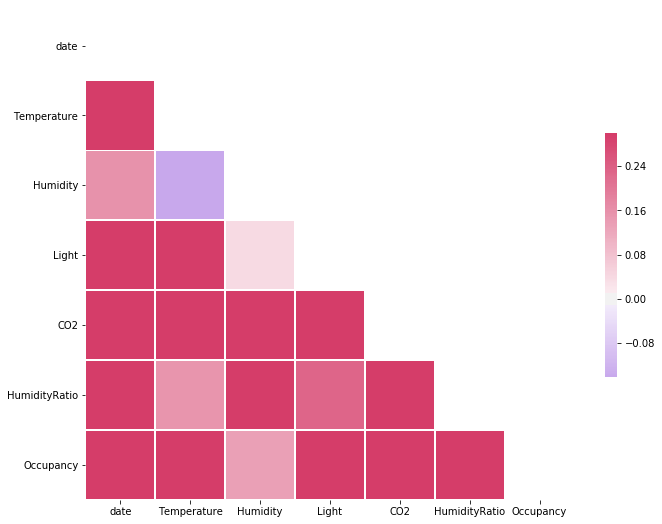

In [55]:
# compute correlation coefficients between columns
corr = df.corr()

# set up mask to visualize correlation between variables
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(1000, 0, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig1 = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig("fig1.png")



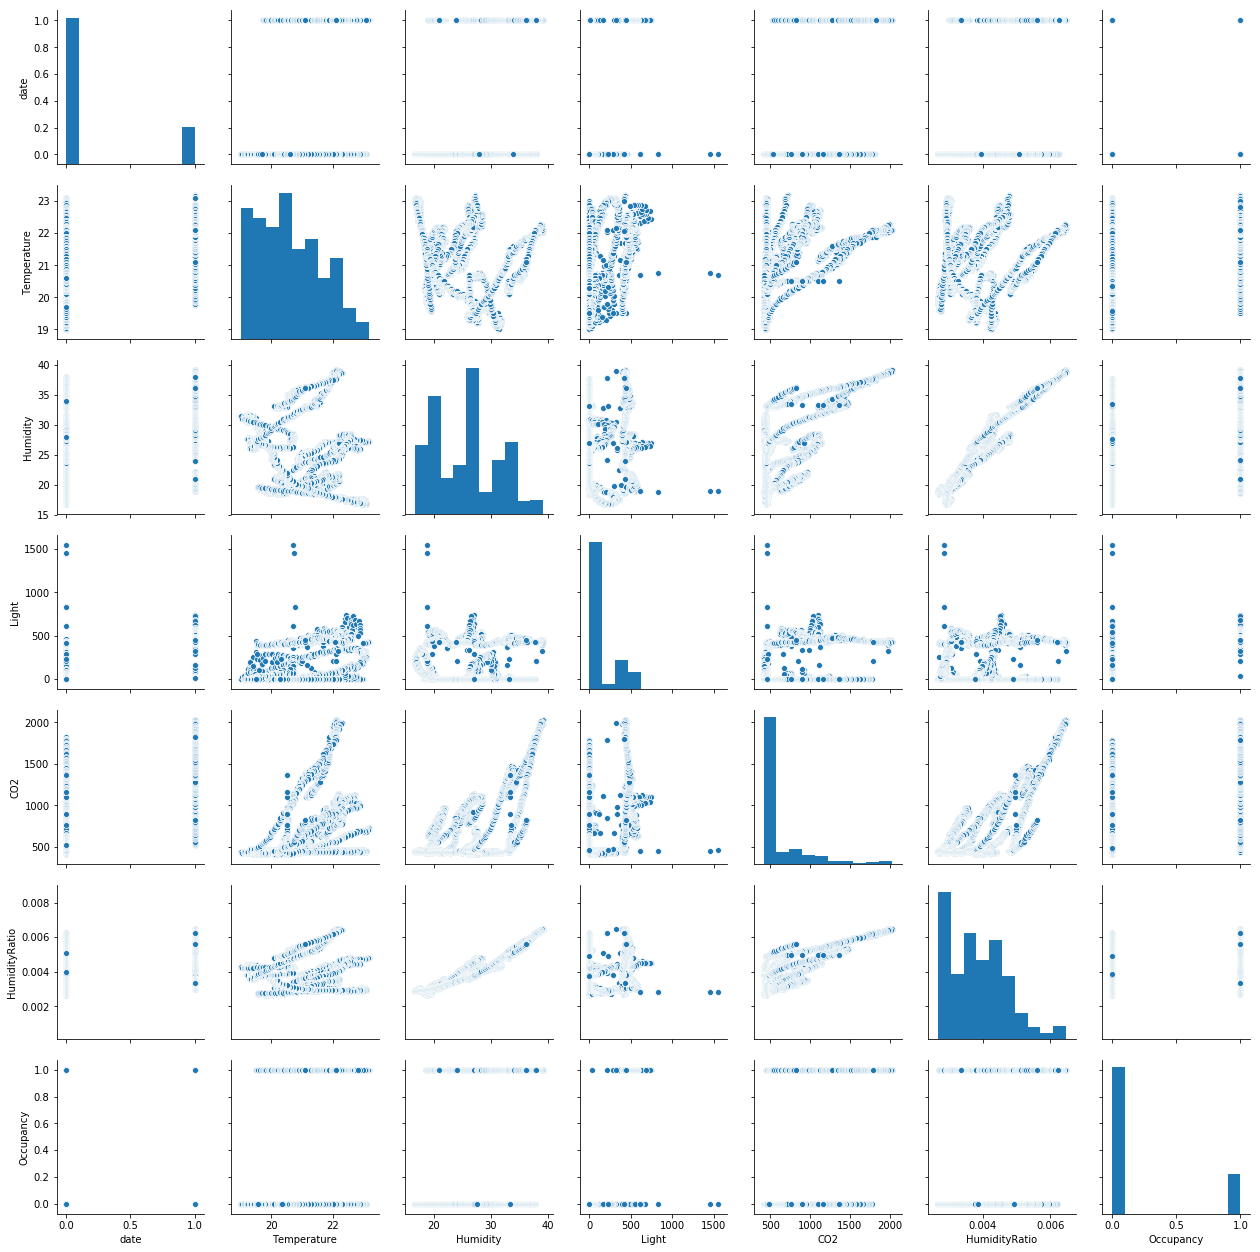

In [56]:
# plot pairplots between variables
fig2 = sns.pairplot(df)
plt.savefig("fig2.png")


In [8]:
# function to load and shuffle train, validation and test data
def load_data():

    # load training validation and test data into dataframes
    train_data = pd.read_csv("Training.txt")
    val_data = pd.read_csv("Validation.txt")
    test_data = pd.read_csv("Test.txt")
    
    

    # shuffle data and return
    return shuffle(train_data), shuffle(val_data), shuffle(test_data)

In [57]:
# function to build data vectors for training of models
def build_data_vectors(train_data, val_data, test_data, params):

    # build X and y vectors for SVM
    X_train = []
    X_val = []
    X_test = []

    if "Temperature" in params:
        # get temperature feature
        temperatures_train = train_data["Temperature"].values
        temperatures_val = val_data["Temperature"].values
        temperatures_test = test_data["Temperature"].values
        X_train.append(temperatures_train)
        X_val.append(temperatures_val)
        X_test.append(temperatures_test)
    
    if "Humidity" in params:
        # get humidity feature
        humidities_train = train_data["Humidity"].values
        humidities_val= val_data["Humidity"].values
        humidities_test= test_data["Humidity"].values
        X_train.append(humidities_train)
        X_val.append(humidities_val)
        X_test.append(humidities_test)
    
    if "Light" in params:
        # get light feature
        lights_train = train_data["Light"].values
        lights_val= val_data["Light"].values
        lights_test= test_data["Light"].values
        X_train.append(lights_train)
        X_val.append(lights_val)
        X_test.append(lights_test)

    if "CO2" in params:
        # get C02 feature
        co2_train = train_data["CO2"].values
        co2_val= val_data["CO2"].values
        co2_test= test_data["CO2"].values
        X_train.append(co2_train)
        X_val.append(co2_val)
        X_test.append(co2_test)

    if "date" in params:
        # get humidity ratio feature
        date_train = train_data["date"].values
        date_val= val_data["date"].values
        date_test= test_data["date"].values
        X_train.append(date_train)
        X_val.append(date_val)
        X_test.append(date_test)

    # build y vectors
    y_train = train_data["Occupancy"].values
    y_val= val_data["Occupancy"].values
    y_test= test_data["Occupancy"].values

    X_train = np.stack(X_train, axis=1)
    X_val = np.stack(X_val, axis=1)
    X_test = np.stack(X_test, axis=1)

    # return vectors
    return X_train, y_train, X_val, y_val, X_test, y_test

In [58]:
def linear_svc(X_train, y_train, X_val, y_val, C, params):

    # define SVM with specified penalty and fit on training data
    print("Running Linear SVM with C=" + str(C) + " and parameters: " + str(params) + "\n")
    clf = svm.LinearSVC(C=C)
    clf.fit(X_train, y_train)

    # predict y values on validation data
    val_preds = clf.predict(X_val)

    # convert to np arrays
    val_preds = np.asarray(val_preds, dtype=np.int)
    y_val = np.asarray(y_val, dtype=np.int)

    # calculate accuracy
    diff = np.absolute(np.subtract(val_preds, y_val))
    mistakes = np.sum(diff)
    accuracy = ((len(diff) - mistakes)*100) / len(diff)
    print("Accuracy: " + str(accuracy) + "%\n")

In [59]:
def logistic_regression(X_train, y_train, X_val, y_val, C, params):
    
    print("Runnig logistic regression with C=" + str(C) + " and parameters: " + str(params) + "\n")
    clf = LogisticRegression(C=C)
    clf.fit(X_train, y_train)
    score = clf.score(X_val, y_val)*100
    print("Accuracy: " + str(score) + "%\n")

In [12]:
# get shuffled dataframes
train_data, val_data, test_data = load_data()

# apply format function to dates in dataframes
train_data['date'] = train_data['date'].map(format_date)
val_data['date'] = val_data['date'].map(format_date)
test_data['date'] = test_data['date'].map(format_date)

# parameters to use for model edit this array to configure which parameters to train model on
parameters = ['Light', 'Temperature']

# build X and y vectors for training validation and testing
X_train, y_train, X_val, y_val, X_test, y_test = build_data_vectors(train_data, val_data, test_data, parameters)

# define hyperparameter constants for SVMs
svm_regularization = [1, 10, 100, 1000]

for i in range(len(svm_regularization)):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        linear_svc(X_train, y_train, X_val, y_val, svm_regularization[i], parameters)
        
# test 
linear_svc(X_train, y_train, X_test, y_test, 100, ['Light', 'Temperature'])


Running Linear SVM with C=1 and parameters: ['Light', 'Temperature']

Accuracy: 97.89868667917449%

Running Linear SVM with C=10 and parameters: ['Light', 'Temperature']

Accuracy: 97.89868667917449%

Running Linear SVM with C=100 and parameters: ['Light', 'Temperature']

Accuracy: 63.63977485928705%

Running Linear SVM with C=1000 and parameters: ['Light', 'Temperature']

Accuracy: 97.86116322701689%

Running Linear SVM with C=100 and parameters: ['Light', 'Temperature']

Accuracy: 98.43109105824446%



/home/sasho/anaconda3/envs/cogs108/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [63]:
# get shuffled dataframes
train_data, val_data, test_data = load_data()

# apply format function to dates in dataframes
train_data['date'] = train_data['date'].map(format_date)
val_data['date'] = val_data['date'].map(format_date)
test_data['date'] = test_data['date'].map(format_date)

# define parameters
parameters = ['Light', 'Temperature']

# build X and y vectors for training validation and testing
X_train, y_train, X_val, y_val, X_test, y_test = build_data_vectors(train_data, val_data, test_data, parameters)

# define regularization constants
logistic_regularization = [1, 0.5 , 0.1, 0.001]

# run logistic regression with set parameters
for i in range(len(logistic_regularization)):
    logistic_regression(X_train, y_train, X_val, y_val, logistic_regularization[i], parameters)
    
# test
logistic_regression(X_train, y_train, X_test, y_test, logistic_regularization[0], parameters)

Runnig logistic regression with C=1 and parameters: ['Light', 'Temperature']

Accuracy: 97.86116322701689%

Runnig logistic regression with C=0.5 and parameters: ['Light', 'Temperature']

Accuracy: 97.86116322701689%

Runnig logistic regression with C=0.1 and parameters: ['Light', 'Temperature']

Accuracy: 97.86116322701689%

Runnig logistic regression with C=0.001 and parameters: ['Light', 'Temperature']

Accuracy: 97.86116322701689%

Runnig logistic regression with C=1 and parameters: ['Light', 'Temperature']

Accuracy: 99.29245283018868%



/home/sasho/anaconda3/envs/cogs108/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sasho/anaconda3/envs/cogs108/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sasho/anaconda3/envs/cogs108/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sasho/anaconda3/envs/cogs108/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sasho/anaconda3/envs/cogs108/lib/python3.7/site-packages/sklearn/linear_model/logistic.py: